In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit 4 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1641014900000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low     Volume
0      2022-01-01 13:44:59  3750.68  3744.44  3765.27  3743.86  2412.6401
1      2022-01-01 13:59:59  3744.44  3735.61  3744.45  3728.60  1010.6714
2      2022-01-01 14:14:59  3735.60  3741.00  3742.67  3728.00  1625.3019
3      2022-01-01 14:29:59  3741.00  3727.65  3741.00  3726.00  1049.1158
4      2022-01-01 14:44:59  3727.74  3723.56  3731.32  3722.33  1024.5073
...                    ...      ...      ...      ...      ...        ...
43223  2023-03-27 20:44:59  1763.24  1758.71  1765.19  1758.38  4324.6014
43224  2023-03-27 20:59:59  1758.72  1756.10  1759.00  1752.49  5269.3450
43225  2023-03-27 21:14:59  1756.10  1754.45  1759.00  1750.63  4465.0949
43226  2023-03-27 21:29:59  1754.45  1756.43  1757.42  1752.04  3237.7225
43227  2023-03-27 21:44:59  1756.42  1756.40  1758.01  1749.11  6879.6949

[43228 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr8
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff()

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

                Close_Time     Open    Close     High      Low     Volume  \
0      2022-01-01 13:44:59  3750.68  3744.44  3765.27  3743.86  2412.6401   
1      2022-01-01 13:59:59  3744.44  3735.61  3744.45  3728.60  1010.6714   
2      2022-01-01 14:14:59  3735.60  3741.00  3742.67  3728.00  1625.3019   
3      2022-01-01 14:29:59  3741.00  3727.65  3741.00  3726.00  1049.1158   
4      2022-01-01 14:44:59  3727.74  3723.56  3731.32  3722.33  1024.5073   
...                    ...      ...      ...      ...      ...        ...   
43223  2023-03-27 20:44:59  1763.24  1758.71  1765.19  1758.38  4324.6014   
43224  2023-03-27 20:59:59  1758.72  1756.10  1759.00  1752.49  5269.3450   
43225  2023-03-27 21:14:59  1756.10  1754.45  1759.00  1750.63  4465.0949   
43226  2023-03-27 21:29:59  1754.45  1756.43  1757.42  1752.04  3237.7225   
43227  2023-03-27 21:44:59  1756.42  1756.40  1758.01  1749.11  6879.6949   

             ema_8       ema_18       ema_38       atr        rsi      slow

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] >= df['ema_38']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4 , 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2022-01-01 13:44:59,3750.68,3744.44,3765.27,3743.86,2412.6401,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2022-01-01 13:59:59,3744.44,3735.61,3744.45,3728.60,1010.6714,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2022-01-01 14:14:59,3735.60,3741.00,3742.67,3728.00,1625.3019,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2022-01-01 14:29:59,3741.00,3727.65,3741.00,3726.00,1049.1158,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2022-01-01 14:44:59,3727.74,3723.56,3731.32,3722.33,1024.5073,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43223,2023-03-27 20:44:59,1763.24,1758.71,1765.19,1758.38,4324.6014,1763.289922,1762.166959,1761.845953,4.748293,44.481213,26.861871,54.899724,False,False,False,True,True,False,False
43224,2023-03-27 20:59:59,1758.72,1756.10,1759.00,1752.49,5269.3450,1761.692161,1761.528332,1761.551289,4.874129,40.599833,20.383964,34.335499,False,False,False,True,False,False,False
43225,2023-03-27 21:14:59,1756.10,1754.45,1759.00,1750.63,4465.0949,1760.082792,1760.783244,1761.187121,5.123834,38.323169,19.519673,22.255169,False,False,False,False,False,False,False
43226,2023-03-27 21:29:59,1754.45,1756.43,1757.42,1752.04,3237.7225,1759.271061,1760.325008,1760.943166,5.142131,42.490700,29.637200,23.180279,True,True,False,False,False,False,False


In [11]:
buydf = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = buydf['Close']
atr_val = buydf['atr']

for index, row in buydf.iterrows():

    if index == 0:
        continue
    
    elif buydf.at[index, 'openbuy'] == True:
   
        buydf.at[index, 'entry_p'] = close_val.shift(1).at[index]
        buydf.at[index, 'stop_loss'] = close_val.shift(1).at[index] - 3 * atr_val.shift(1).at[index]
        buydf.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = buydf.at[index, 'stop_loss']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and buydf.at[index, 'Close'] < stop_loss:
        buydf.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan

    # set take profit
    elif (buydf.at[index, 'High'] >= close_val.shift(1).at[index] + 4 * atr_val.shift(1).at[index]) and in_position == True:
        buydf.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan

buydf.to_csv('buydf.csv')
        
raw_entry_df = buydf.copy()

# 過濾有訊號或事件發生的Ｋ線
buydf = buydf[(buydf['openbuy'] == True) |
              (buydf['signal'] == True) | 
              (buydf['position'] == 'Buy') |
              (buydf['position'] == 'Sell') |
              (buydf['position'] == 'Stop')]


print(buydf)


                Close_Time     Open    Close     High      Low     Volume  \
44     2022-01-02 00:44:59  3744.30  3739.64  3747.35  3735.35  1323.2678   
45     2022-01-02 00:59:59  3739.87  3727.62  3744.57  3725.16  2428.8527   
47     2022-01-02 01:29:59  3728.93  3735.31  3737.01  3727.84  1010.0114   
48     2022-01-02 01:44:59  3735.30  3757.82  3763.65  3735.00  4122.0794   
50     2022-01-02 02:14:59  3760.76  3754.71  3766.00  3751.20  1418.6671   
...                    ...      ...      ...      ...      ...        ...   
43174  2023-03-27 08:29:59  1772.92  1778.37  1779.69  1772.91  3494.2304   
43175  2023-03-27 08:44:59  1778.37  1777.09  1779.47  1773.93  4164.1069   
43193  2023-03-27 13:14:59  1764.63  1760.68  1765.62  1760.14  2175.0271   
43221  2023-03-27 20:14:59  1765.42  1767.30  1767.30  1763.85  2222.5450   
43222  2023-03-27 20:29:59  1767.29  1763.25  1769.33  1762.02  4302.8973   

             ema_8       ema_18       ema_38        atr  ...  kd_cross     

In [12]:
# 部位回測

posdf = buydf.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Buy') |
              (posdf['position'] == 'Sell') |
              (posdf['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss']
pos = posdf[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'Close'] + 4 * pos.at[i, 'atr']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位來代表總進場成本，以計算報酬率
pos['consec_entry'] = (pos['position'] != pos['position'].shift()).cumsum()
group_consec = pos.groupby('consec_entry').apply(lambda x:x.loc[x['position'] == 'Buy', 'amt' ].sum())
max_entry = group_consec.max()

profit_per = "{:.2f}%".format(ttl_profit / (max_entry/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()
total_pos = pos['position']
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Entry': [round(max_entry, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



               Close_Time     Open    Close     High      Low        ema_8  \
0     2022-01-02 00:59:59  3739.87  3727.62  3744.57  3725.16  3728.795160   
1     2022-01-02 01:44:59  3735.30  3757.82  3763.65  3735.00  3736.389273   
2     2022-01-02 02:29:59  3754.72  3749.05  3757.97  3745.00  3745.646832   
3     2022-01-02 03:14:59  3752.58  3749.35  3757.86  3746.18  3747.530046   
4     2022-01-02 03:29:59  3749.36  3744.38  3749.84  3736.31  3746.830036   
...                   ...      ...      ...      ...      ...          ...   
5706  2023-03-26 22:59:59  1769.72  1763.63  1773.24  1753.02  1776.252597   
5707  2023-03-27 07:14:59  1776.07  1777.61  1780.35  1774.39  1771.692316   
5708  2023-03-27 07:44:59  1777.80  1777.74  1781.37  1777.03  1774.091895   
5709  2023-03-27 08:44:59  1778.37  1777.09  1779.47  1773.93  1775.316528   
5710  2023-03-27 13:14:59  1764.63  1760.68  1765.62  1760.14  1764.625336   

           ema_18       ema_38        atr kd_cross position  en

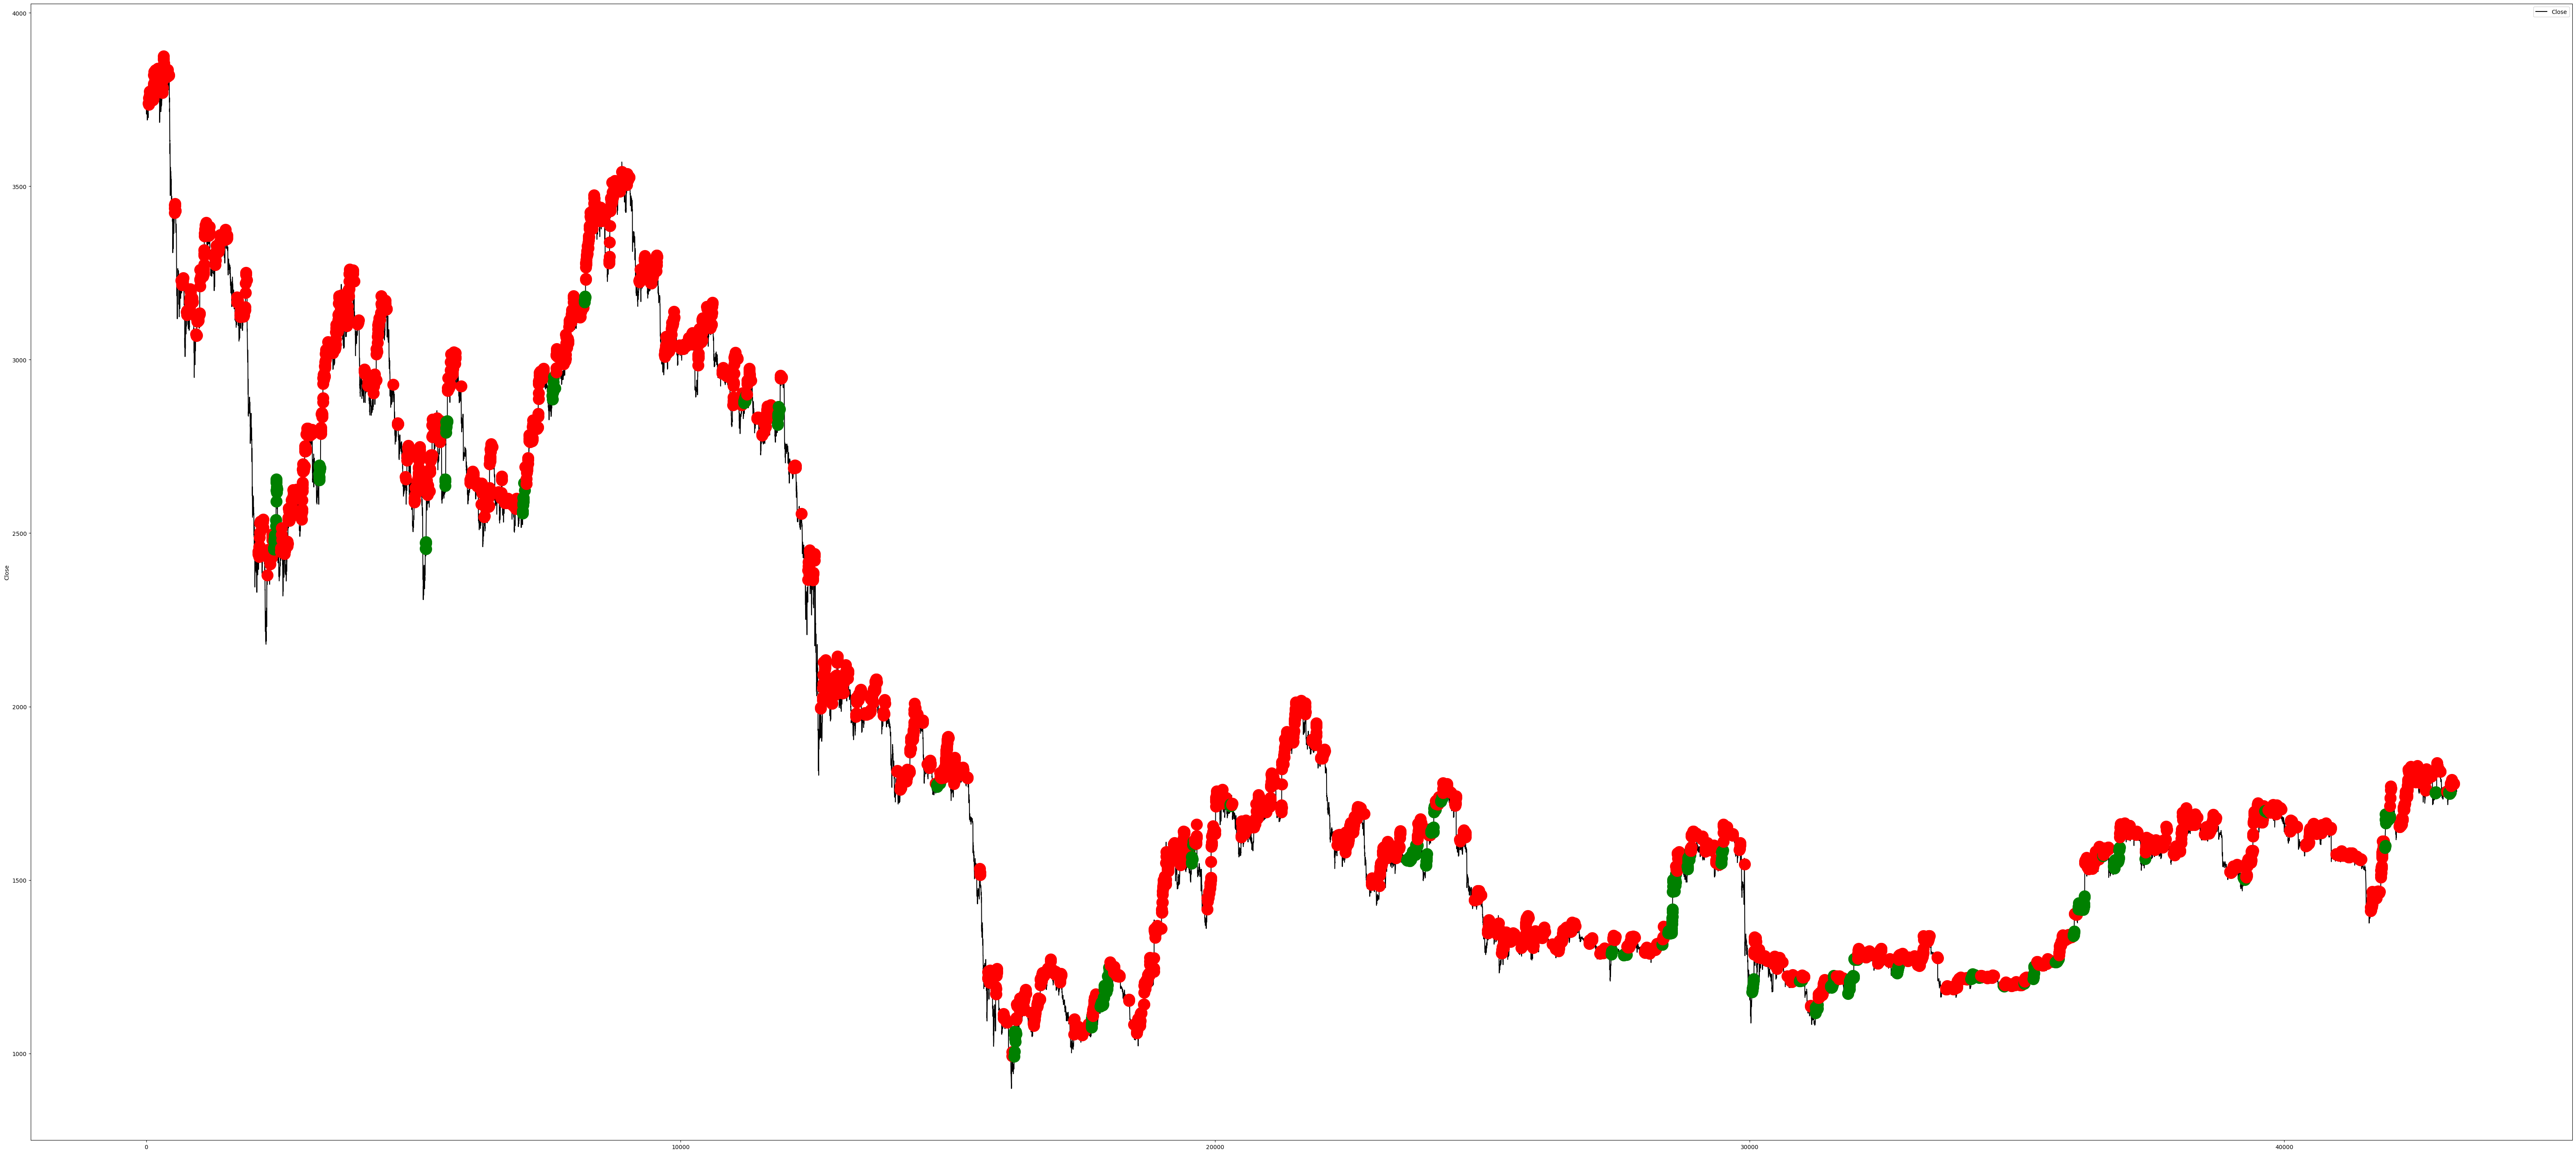

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位